# Races - Density Based Clustering (DBSCAN)

### Data Mining Project 2024/25

Authors: Nicola Emmolo, Simone Marzeddu, Jacopo Raffi

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.cluster.hierarchy import fcluster

from scipy.spatial.distance import pdist, squareform
from kneed import KneeLocator

In [3]:
dataset = pd.read_csv('../../data/complete_dataset_fe.csv', dtype={'cyclist_team': str})
dataset['date'] = pd.to_datetime(dataset['date'], format='%Y-%m-%d')
dataset = dataset[['length','race_prestige', 'race_physical_effort']].drop_duplicates()

In [4]:
'''
Clustering Features Races:
- race_prestige (ignore: points, uci_points, startlist_quality)
- race_physical_effort (ignore: climb_total, profile, climb_percentage)
- lenght

Additionally, ignore race_year (not informative for clustering in our opinion)
'''

'\nClustering Features Races:\n- race_prestige (ignore: points, uci_points, startlist_quality)\n- race_physical_effort (ignore: climb_total, profile, climb_percentage)\n- lenght\n\nAdditionally, ignore race_year (not informative for clustering in our opinion)\n'

In [5]:
# Select relevant columns for clustering
columns_to_use = ['length','race_prestige', 'race_physical_effort']

data_for_clustering = dataset.dropna() #TODO: remove when we have imputed the missing values

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_for_clustering)

#### Model Selection

In [6]:
dist = squareform(pdist(data_scaled, 'euclidean'))
min_points = range(2, 20)
optimal_eps = []
optimal_index = []
cluster_count = []
silhouette_scores = []



for i, value in enumerate(min_points):
    k = value - 1 #standard value?
    
    #print("k = ", k)
    
    kth_distances = list()
    for d in dist:
        index_kth_distance = np.argsort(d)[k]
        kth_distances.append(d[index_kth_distance])

    sorted_distances = sorted(kth_distances)
    indices = range(0, len(kth_distances))
    
    #print("sorted_distances = ", sorted_distances)
    #print("indices = ", indices)

    # Use the KneeLocator to find the knee point
    kneedle = KneeLocator(indices, sorted_distances, curve="convex", direction="increasing")

    #print("kneedle.knee = ", kneedle.knee)
    
    if(kneedle.knee is None):
        optimal_eps.append(None)  # The y-value at the knee
        optimal_index.append(None)  # The x-value (index)
        silhouette_scores.append(None)
        continue
    
    # Get the knee (optimal epsilon)
    optimal_eps.append(sorted_distances[kneedle.knee])  # The y-value at the knee
    optimal_index.append(kneedle.knee)  # The x-value (index)
    
    # Apply DBSCAN
    dbscan = DBSCAN(eps=optimal_eps[i], min_samples=value)
    clusters = dbscan.fit_predict(data_scaled)

    # Add cluster labels to the data
    data_for_clustering['cluster'] = clusters
    number_of_clusters = data_for_clustering['cluster'].nunique()
    cluster_count.append(number_of_clusters)
    
    if(number_of_clusters < 3): # Considering that a cluster is that of outliers, to compite silhouette we need at least 3 clusters here
        silhouette_scores.append(None)
        continue
    
    # Removing outliers so to not include them in silhouette calculation
    no_out_data_scaled = scaler.fit_transform(data_for_clustering[data_for_clustering['cluster'] != -1])
    no_out_labels = dbscan.labels_[dbscan.labels_ != -1]

    # Calculate Silhouette
    silhouette_scores.append(silhouette_score(no_out_data_scaled, no_out_labels))
    

# Creating the DataFrame
model_selection_data = {"min_points": min_points, "optimal_eps": optimal_eps, "optimal_index": optimal_index, "cluster_count": cluster_count, "silhouette_score": silhouette_scores}
model_selection_df = pd.DataFrame(model_selection_data)

model_selection_df

/tmp/ipykernel_31167/2745289044.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_for_clustering['cluster'] = clusters
/tmp/ipykernel_31167/2745289044.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_for_clustering['cluster'] = clusters
/tmp/ipykernel_31167/2745289044.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

,min_points,optimal_eps,optimal_index,cluster_count,silhouette_score
0,2,0.354863,2575,17,0.079048
1,3,0.370991,2546,6,0.588696
2,4,0.434807,2549,4,0.702455
3,5,0.513601,2562,2,NaN
4,6,0.515550,2553,2,NaN
5,7,0.596807,2568,2,NaN
6,8,0.598930,2559,2,NaN
7,9,0.628372,2559,2,NaN
8,10,0.578580,2533,3,0.864133
9,11,0.652037,2554,2,NaN


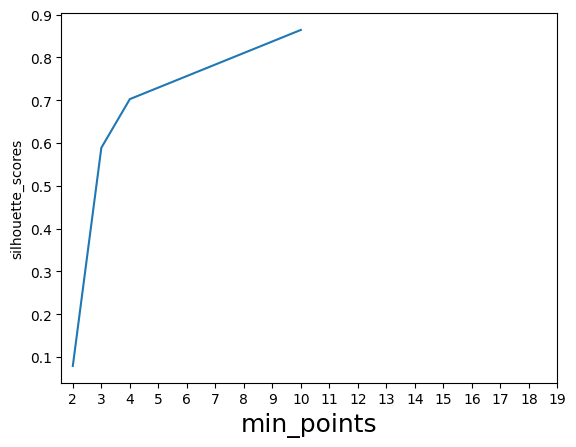

In [7]:
x = model_selection_df[model_selection_df['cluster_count'] > 2]['min_points']
y = model_selection_df[model_selection_df['cluster_count'] > 2]['silhouette_score']

plt.plot(x, y)
plt.ylabel('silhouette_scores')
plt.xlabel('min_points', fontsize=18)
plt.xticks(min_points)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.show()

#### Chosen Parameters Clustering

(3407355,)
(2611, 2611)
Optimal epsilon (eps): 0.5785801376594045
Knee point index: 2533


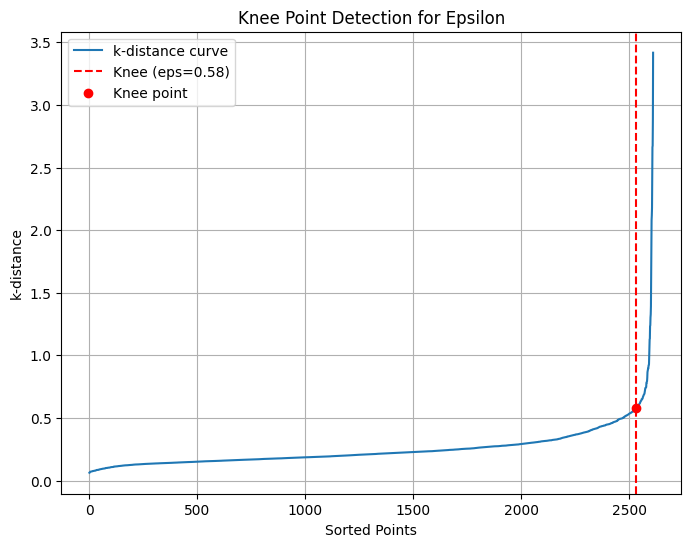

In [8]:
min_points = 10

dist = pdist(data_scaled, 'euclidean') #pair wise distance
print (dist.shape)
dist = squareform(dist) #distance matrix given the vector dist
print(dist.shape)

k = min_points - 1 #standard value?
kth_distances = list()
for d in dist:
    index_kth_distance = np.argsort(d)[k]
    kth_distances.append(d[index_kth_distance])

sorted_distances = sorted(kth_distances)
indices = range(0, len(kth_distances))

# Use the KneeLocator to find the knee point
kneedle = KneeLocator(indices, sorted_distances, curve="convex", direction="increasing")

# Get the knee (optimal epsilon)
optimal_eps = sorted_distances[kneedle.knee]  # The y-value at the knee
optimal_index = kneedle.knee  # The x-value (index)

print(f"Optimal epsilon (eps): {optimal_eps}")
print(f"Knee point index: {optimal_index}")

# Plot the k-distance graph with the knee point marked
plt.figure(figsize=(8, 6))
plt.plot(indices, sorted_distances, label="k-distance curve")
plt.axvline(optimal_index, linestyle="--", color="r", label=f"Knee (eps={optimal_eps:.2f})")
plt.scatter(optimal_index, optimal_eps, color="red", label="Knee point", zorder=5)
plt.xlabel("Sorted Points")
plt.ylabel("k-distance")
plt.title("Knee Point Detection for Epsilon")
plt.legend()
plt.grid()
plt.show()

Selection of best eps

In [9]:
# Apply DBSCAN
dbscan = DBSCAN(eps=optimal_eps, min_samples=min_points)
clusters = dbscan.fit_predict(data_scaled)

# Add cluster labels to the data
data_for_clustering['cluster'] = clusters

# Display cluster distribution
print(data_for_clustering['cluster'].value_counts())
print(data_for_clustering.head())

cluster
 0    2571
-1      29
 1      11
Name: count, dtype: int64
   length  race_prestige  race_physical_effort  cluster
4     5.2       0.193636              0.000024        0
5   135.0       0.193636              0.011103        0
6   100.0       0.193636              0.007473        0
7   199.0       0.193636              0.069027        0
8   244.0       0.193636              0.156260        0


/tmp/ipykernel_31167/4157897731.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_for_clustering['cluster'] = clusters


In [10]:
np.unique(dbscan.labels_, return_counts=True)

(array([-1,  0,  1]), array([  29, 2571,   11]))

In [11]:
# Identify outliers (cluster label -1)
outliers = data_for_clustering[data_for_clustering['cluster'] == -1]
print("\nNumber of outliers:", len(outliers))


Number of outliers: 29


In [12]:
# Analyze the mean and standard deviation of numerical features for each cluster
cluster_stats = data_for_clustering.groupby('cluster').agg(['mean', 'std'])
print("Cluster Statistics:\n", cluster_stats)

Cluster Statistics:
              length            race_prestige           race_physical_effort  \
               mean        std          mean       std                 mean   
cluster                                                                       
-1       262.196552  25.646463      0.451813  0.247190             0.454624   
 0       164.991855  60.100031      0.164046  0.092988             0.172400   
 1       295.454545   4.180039      0.483298  0.031763             0.183003   

                   
              std  
cluster            
-1       0.320791  
 0       0.157208  
 1       0.028747  


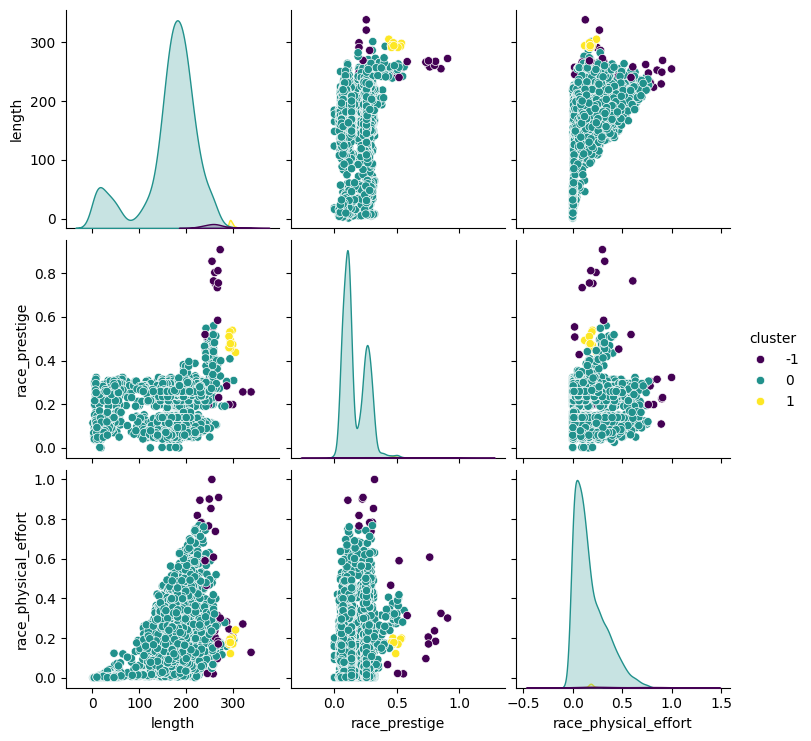

In [13]:
# Pair plot for a subset of columns
data_subset = data_for_clustering[['length','race_prestige', 'race_physical_effort', 'cluster']]
sns.pairplot(data_subset, hue='cluster', palette='viridis')
plt.show()

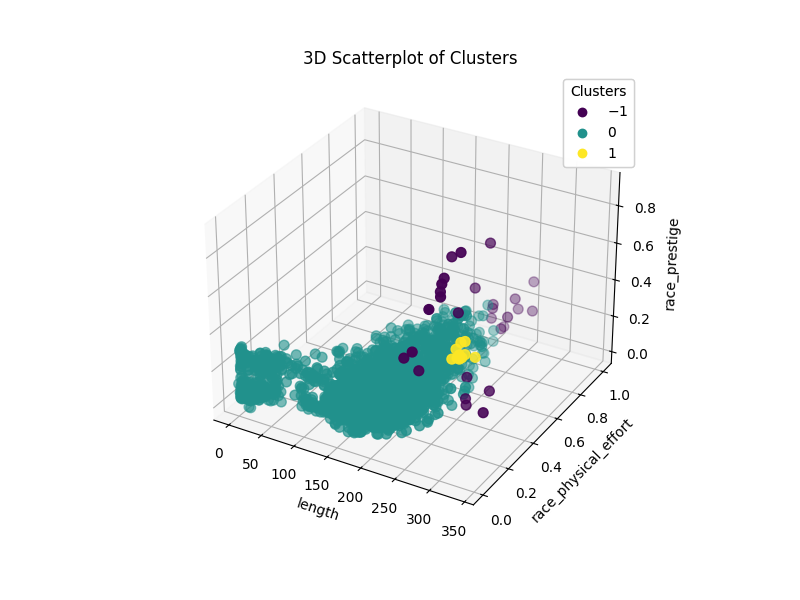

In [14]:
%matplotlib widget

x = data_for_clustering['length']  # Prima feature
y = data_for_clustering['race_physical_effort']  # Seconda feature
z = data_for_clustering['race_prestige']  # Terza feature

# Crea il grafico 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatterplot
scatter = ax.scatter(x, y, z, c=data_for_clustering['cluster'], cmap='viridis', s=50)
ax.set_xlabel('length')
ax.set_ylabel('race_physical_effort')
ax.set_zlabel('race_prestige')

# Aggiungi una legenda (opzionale)
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

plt.title('3D Scatterplot of Clusters')

# Abilita la modalità interattiva
plt.ion()
plt.show()

In [15]:
data_scaled = scaler.fit_transform(data_for_clustering[data_for_clustering['cluster'] != -1])
no_out_labels = dbscan.labels_[dbscan.labels_ != -1]

In [16]:
print('Silhouette %s' % silhouette_score(data_scaled, no_out_labels))

Silhouette 0.8641333452917146
